In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
import numpy as np

In [33]:
# meta = pd.read_csv("geo_metadata.csv")

In [60]:
barcode_clones = pd.read_csv("barcode_clonotypes.csv")
order_of_timepoints = {"IP": 0, "Early": 1, "Contraction": 2, "Late": 3}
barcode_clones["time_point_idx"] = barcode_clones["time_point_type"].map(order_of_timepoints)

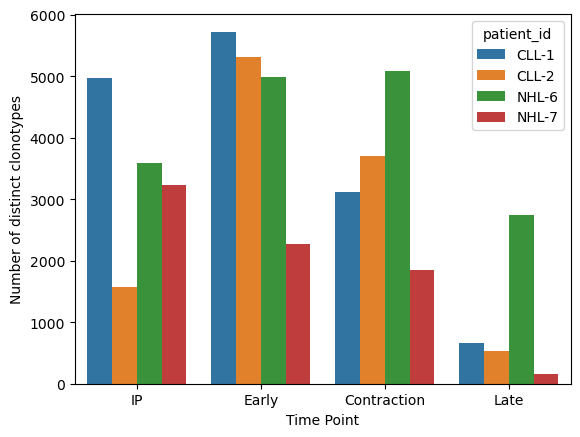

In [68]:
counts_per_timepoint = barcode_clones.groupby(["time_point_type", "patient_id"]).count().reset_index()[["cdr3", "time_point_type", "patient_id", "clone_id"]]
order_of_timepoints = {"IP": 0, "Early": 1, "Contraction": 2, "Late": 3}
counts_per_timepoint["time_point_idx"] = counts_per_timepoint["time_point_type"].map(order_of_timepoints)

sns.barplot(x="time_point_idx", y="cdr3", hue="patient_id", data=counts_per_timepoint)
plt.xticks([0, 1, 2, 3], ["IP", "Early", "Contraction", "Late"])
plt.xlabel("Time Point")
plt.ylabel("Number of distinct clonotypes")
plt.show()

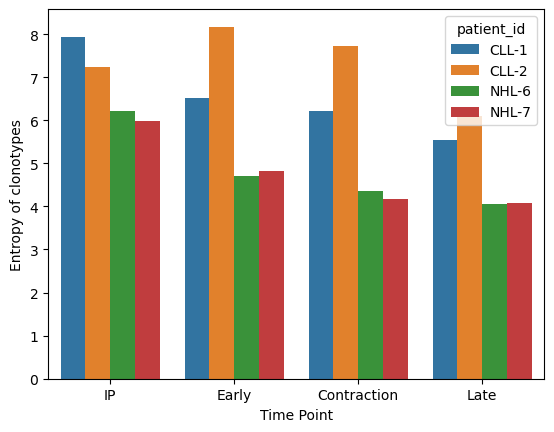

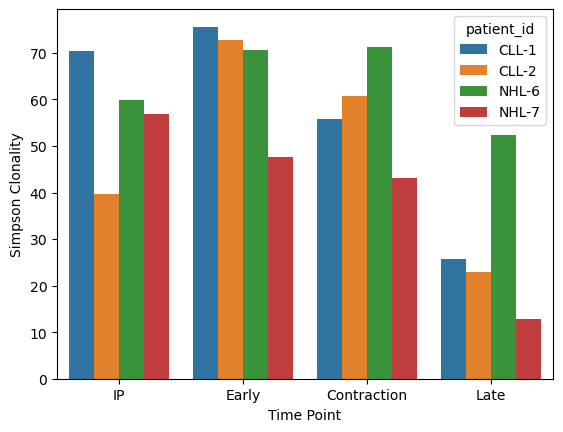

In [69]:
# Measure the entropy of the clonotypes per time point
def clonal_entropy(clone_labels):
    value,counts = np.unique(clone_labels, return_counts=True)
    return entropy(counts)

def simpson_clonality(clone_labels):
    value,counts = np.unique(clone_labels, return_counts=True)
    return np.sqrt(np.sum(np.square(counts)))

entropy_per_timepoint = barcode_clones.groupby(["time_point_type", "patient_id"]).agg({"clone_id": clonal_entropy, "barcode": simpson_clonality}).reset_index()
entropy_per_timepoint["time_point_idx"] = counts_per_timepoint["time_point_type"].map(order_of_timepoints)

sns.barplot(x="time_point_idx", y="clone_id", hue="patient_id", data=entropy_per_timepoint)
plt.xticks([0, 1, 2, 3], ["IP", "Early", "Contraction", "Late"])
plt.xlabel("Time Point")
plt.ylabel("Entropy of clonotypes")
plt.show()

sns.barplot(x="time_point_idx", y="barcode", hue="patient_id", data=entropy_per_timepoint)
plt.xticks([0, 1, 2, 3], ["IP", "Early", "Contraction", "Late"])
plt.xlabel("Time Point")
plt.ylabel("Simpson Clonality")
plt.show()


In [41]:
# look at most comomon in IP and follow them
# top_clones_in_ip = barcode_clones.query("time_point_type == 'IP'").groupby("patient_id").agg({"clone_id": lambda x: x.value_counts().index[:10]})["clone_id"].explode().values

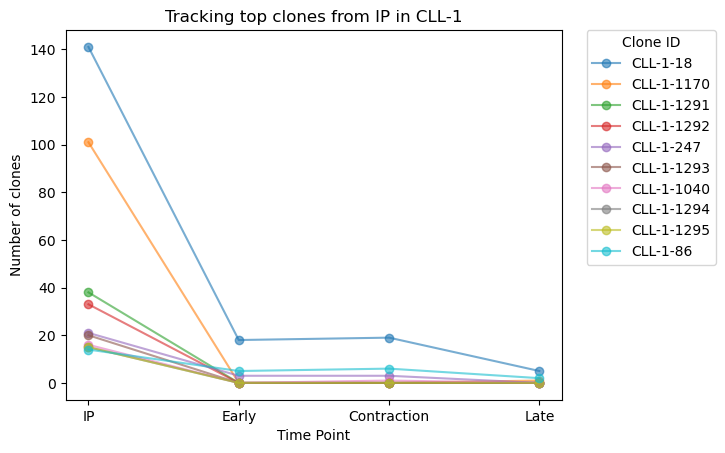

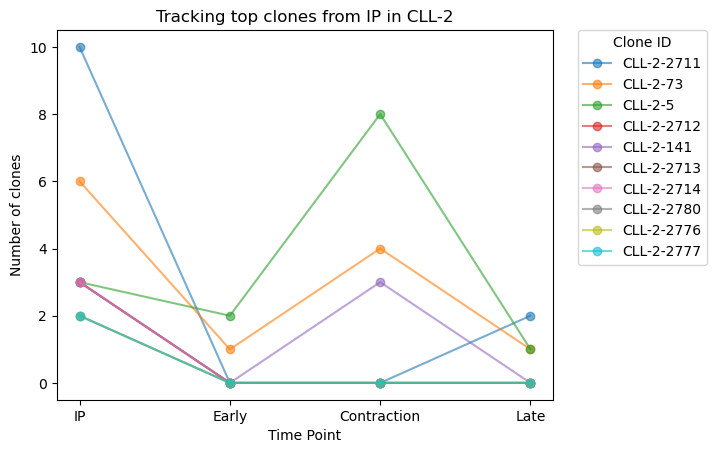

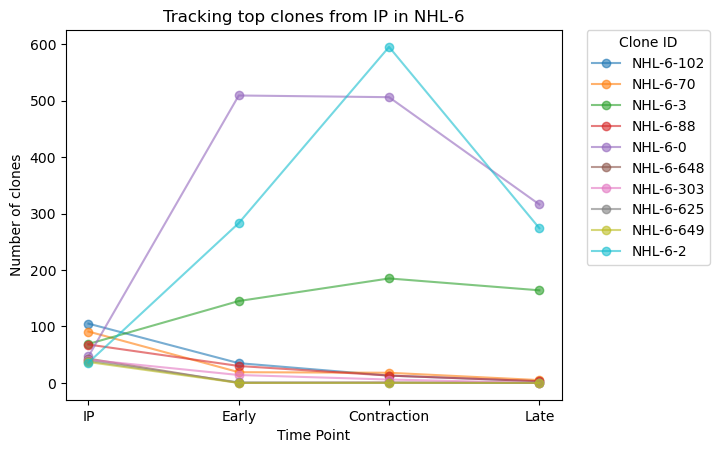

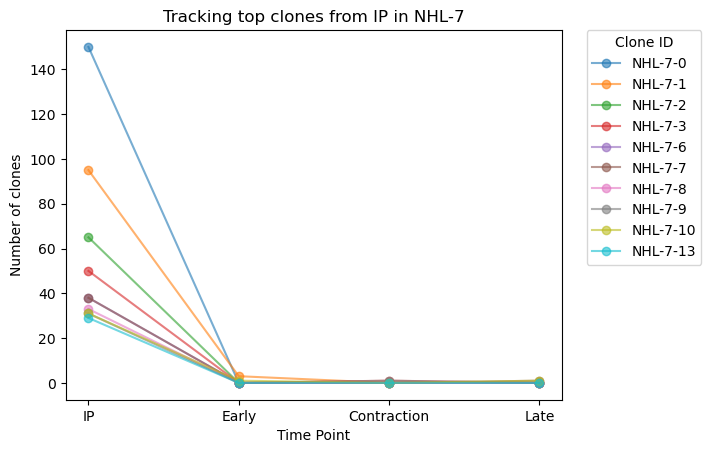

In [118]:
for patient_id, patient_group in barcode_clones.groupby("patient_id"):
    top_clones_in_ip = patient_group.query("time_point == 'IP'")["clone_id"].value_counts().index[:10]
    for clone in top_clones_in_ip:
        clone_df = patient_group.query("clone_id == @clone").groupby("time_point_idx").count()["clone_id"]
        for time_pt in [0,1,2,3]:
            if time_pt not in clone_df.index:
                clone_df.loc[time_pt] = 0
        plt.plot(clone_df.sort_index(), label=clone, marker="o", alpha=0.6)

    plt.xticks([0, 1, 2, 3], ["IP", "Early", "Contraction", "Late"])
    plt.xlabel("Time Point")
    plt.ylabel("Number of clones")
    plt.title(f"Tracking top clones from IP in {patient_id}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title="Clone ID")
    plt.show()



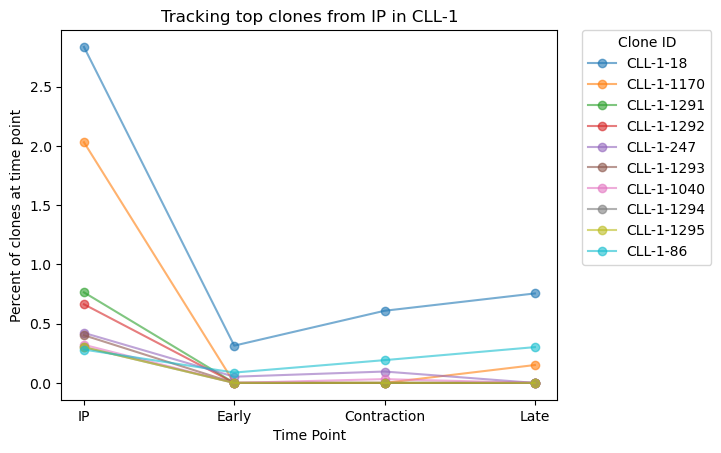

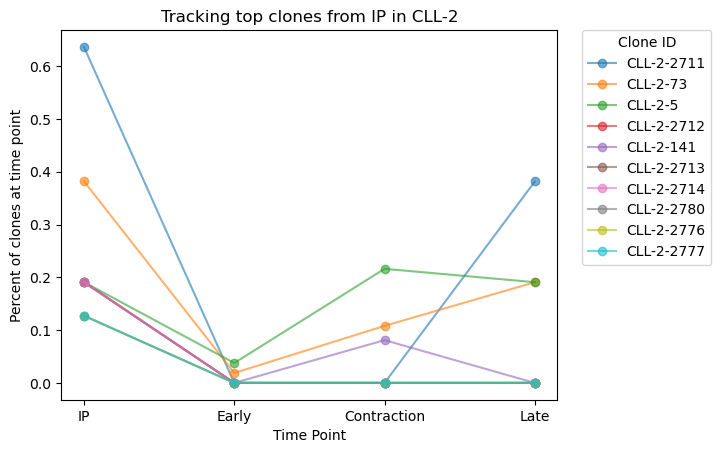

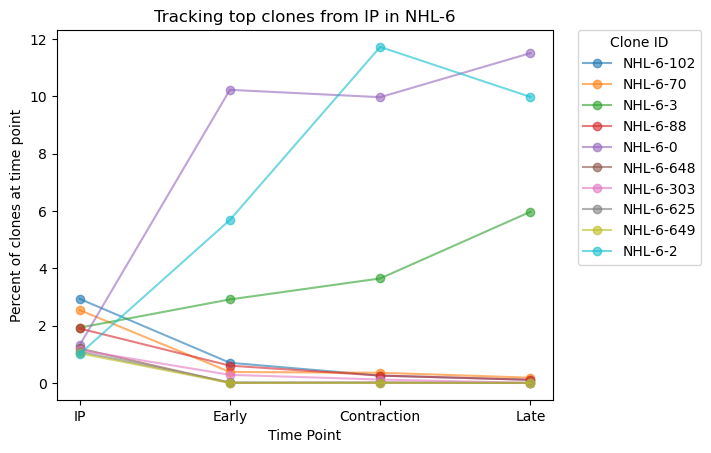

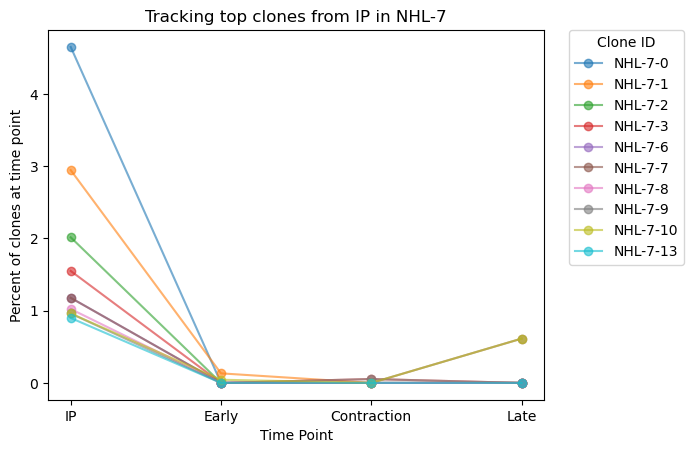

In [127]:
for patient_id, patient_group in barcode_clones.groupby("patient_id"):
    top_clones_in_ip = patient_group.query("time_point == 'IP'")["clone_id"].value_counts().index[:10]
    total_reads_per_timepoint = patient_group["time_point_idx"].value_counts()
    for clone in top_clones_in_ip:
        clone_df = patient_group.query("clone_id == @clone").groupby("time_point_idx").count()["clone_id"]
        for time_pt in [0,1,2,3]:
            if time_pt not in clone_df.index:
                clone_df.loc[time_pt] = 0
            else:
                clone_df.loc[time_pt] = (clone_df.loc[time_pt] / total_reads_per_timepoint.loc[time_pt]) * 100
        plt.plot(clone_df.sort_index(), label=clone, marker="o", alpha=0.6)

    plt.xticks([0, 1, 2, 3], ["IP", "Early", "Contraction", "Late"])
    plt.xlabel("Time Point")
    plt.ylabel("Percent of clones at time point")
    plt.title(f"Tracking top clones from IP in {patient_id}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title="Clone ID")
    plt.show()

